# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
**Actividad Curvas ROC y PR**


# **Itroducción**

La actividad se basa en los datos conocidos como "oil-spill" (derrame de petróleo).

El archivo de los datos está en Canvas y se llama "oil-spill.csv".


En la siguiente liga se encuentra la liga del artículo relacionado a dicha base de datos. Los datos incluyen 50 columnas y 937 registros. Las primeras 49 columnas son métricas obtenidas de imágenes satelitales del océano, en algunas de las cuales se tiene petróleo que fue derramado por alguna fuente desconocida. En el artículo se describe a detalle la manera en que se obtuvieron dichas columnas. Para la actividad es suficiente considerarlas como de valor numérico. La última columna es de valor 1 (hay derrame en esa sección de la imagen) o 0 (no hay derrame en esa sección de la imagen).

https://webdocs.cs.ualberta.ca/~holte/Publications/oilspill.pdf

En la siguiente liga puedes encontrar información de varias de las métricas que estaremos utilizando:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

La media geométrica se puede obtener combinando las métricas anteriores, pero para fines prácticos usaremos la de la librería llamada "imbalanced-learn":

https://glemaitre.github.io/imbalanced-learn/generated/imblearn.metrics.geometric_mean_score.html

In [ ]:
# Incluye todas las librerías que consideres adecuadas:

from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

Mounted at /content/drive


Para fines de la actividad procesaremos los datos de manera estándar para concentrarnos en los temas de la actividad.

In [ ]:
path = 'oil_spill.csv'
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4030 - Inteligencia Artificial y Aprendizaje Automatico/Semana 4/"
os.chdir(DIR)
df = read_csv(path, header=None)   # no tienen nombre las columnas

print('Dimensión del DataFrame',df.shape)

# eliminamos las siguientes columnas:
df.drop(22, axis=1, inplace=True)    # Esta columna tiene un solo valor constante.
df.drop(0, axis=1, inplace=True)     # Esta columna contiene información de secciones (batches) de las imágenes, que no la requerimos.

df.columns = [i for i in range(df.shape[1])]   # Renombramos las columnas para que sean enteros consecutivos.

# Particionamos los datos de entrada (X) y de salida (y):
X,y = df.iloc[:,:-1], df.iloc[:,-1]

Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.12, stratify=y, shuffle=True, random_state=0)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.2, shuffle=True, random_state=5)
print('\nPartición:')
print('Train: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytrain.sum(), 100*(ytrain.sum() / len(ytrain))))
print('Val: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (yval.sum(), 100*(yval.sum() / len(yval))))
print('Test: Conteo clase positiva=%d, Porcentaje=%.2f%%' % (ytest.sum(), 100*(ytest.sum() / len(ytest))))

Dimensión del DataFrame (937, 50)

Partición:
Train: Conteo clase positiva=29, Porcentaje=4.40%
Val: Conteo clase positiva=7, Porcentaje=4.24%
Test: Conteo clase positiva=5, Porcentaje=4.42%


Breve descripción numérica y gráfica del conjunto de entrenamiento:

In [ ]:
Xtrain.describe().T

,count,mean,std,min,25%,50%,75%,max
0,659.0,344.153263,1.880555e+03,10.00,22.000,65.00,134.500,28526.00
1,659.0,709.286161,5.993162e+02,1.95,97.475,727.45,1242.135,1893.08
2,659.0,867.791608,5.145066e+02,1.00,445.065,791.35,1243.220,2674.16
3,659.0,85.078907,4.573682e+01,0.00,55.000,74.00,119.000,180.00
4,659.0,824339.418816,4.131627e+06,70312.00,127500.000,187500.00,348750.000,71315000.00
5,659.0,42.966449,1.259403e+01,21.24,33.430,39.64,51.975,82.64
6,659.0,9.162307,3.587007e+00,0.83,6.920,8.22,10.755,24.28
7,659.0,4119.098634,8.899523e+03,667.00,1404.750,2167.00,3600.000,160740.00
8,659.0,0.222898,8.984421e-02,0.02,0.170,0.21,0.260,0.74
9,659.0,110.288771,6.272348e+01,47.00,82.950,99.80,115.700,901.70


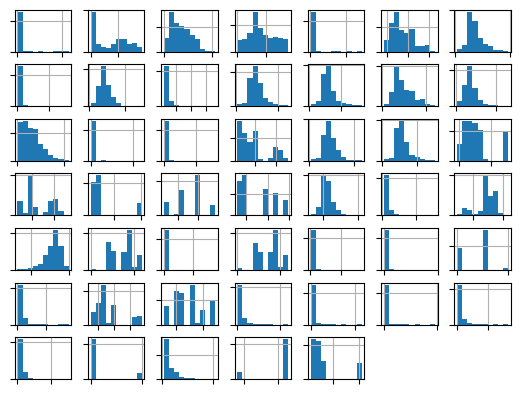

In [ ]:
ax = Xtrain.hist()  # Histogramas:
# Quitemos toda la información del gráfico para visualizarlo de manera sencilla:
for axis in ax.flatten():
  axis.set_title('')
  axis.set_xticklabels([])
  axis.set_yticklabels([])
plt.show()

In [ ]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 770 to 460
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int64  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    int64  
 4   4       659 non-null    float64
 5   5       659 non-null    float64
 6   6       659 non-null    float64
 7   7       659 non-null    float64
 8   8       659 non-null    float64
 9   9       659 non-null    float64
 10  10      659 non-null    float64
 11  11      659 non-null    float64
 12  12      659 non-null    float64
 13  13      659 non-null    float64
 14  14      659 non-null    float64
 15  15      659 non-null    float64
 16  16      659 non-null    float64
 17  17      659 non-null    float64
 18  18      659 non-null    float64
 19  19      659 non-null    float64
 20  20      659 non-null    float64
 21  21      659 non-null    float64
 22  22   

In [ ]:
# Código-1:
# Aplicamos la función Dummy:

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(geometric_mean_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


modeloD = DummyClassifier(strategy='uniform')
scores = evaluate_model(X, y, modeloD)

print('Métrica G-mean - Media Geométrica: %.3f (%.3f)' % (mean(scores), std(scores)))

Métrica G-mean - Media Geométrica: 0.487 (0.197)


# **Ejercicio-1**

### **Explica lo que hace cada línea de código de la celda anterior llamada "Código-1", así como lo que significa el valor que se obtiene en su salida:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



1.   Define una función para evaluar un modelo con inputs de X, y y un modelo.
2.    Define una estrategia de validación cruzada a utilizar. En este caso se dividen los datos en 10 grupos y se repite el proceso 3 veces para mayor estabilidad. También se genera una semilla con los random_state lo que garantiza que la partición de los datos sea siempre la misma en cada ejecución.
3.   Define una métrica de evaluación basada en la media geométrica
4.   Aplica validación cruzada al modelo usando la métrica definida (media geométrica) y la estrategia de validación (cross validation). Se usa n_jobs=-1 para aprovechar todos los núcleos del procesador y acelerar el cálculo.
5.   Devuelve un arreglo con los puntajes de la métrica G-mean obtenidos en cada iteración de la validación cruzada.
6.   Crea un modelo de clasificación base, a través de la fuunción DummyClassifier, que asigna etiquetas de manera aleatoria con estrategia uniforme a los datos. Se usa como referencia para comparar modelos más sofisticados.
7.   Evalúa el clasificador Dummy con la función previamente hecha. Como output se obtienen los scores del clasificador.
8.   Imprime el valor promedio y la desviación estándar de los puntajes G-mean, lo que indica el desempeño del modelo en diferentes divisiones de los datos.
9.   Significado del valor de salida:El valor de G-mean indica qué tan bien el modelo equilibra la clasificación de ambas clases, especialmente en conjuntos de datos desbalanceados. Entre más cercano a 1 se tiene un modelo con mejor equilibrio en las clases que con valores más pequeños.




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

Para fines de esta actividad definimos las siguientes transformaciones del preprocesamiento de los datos:

In [ ]:
# Transforamaciones numéricas:

numericas_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='mean')),
                                       ('std_transformer', StandardScaler())])
numericas_pipeline_nombres = Xtrain.columns

columnasTransformer = ColumnTransformer(transformers = [('num', numericas_pipeline, numericas_pipeline_nombres)],
                                        remainder='passthrough')

In [ ]:
mi_metrica = make_scorer(geometric_mean_score)  # definimos la métrica G-mean

Resultados de Validación:
LR
Exactitud: >> 0.951 (0.015)
G-mean: >> 0.741 (0.079)

LASSO
Exactitud: >> 0.968 (0.009)
G-mean: >> 0.689 (0.104)

RIDGE
Exactitud: >> 0.969 (0.011)
G-mean: >> 0.725 (0.108)

EN
Exactitud: >> 0.968 (0.010)
G-mean: >> 0.694 (0.112)

kNN
Exactitud: >> 0.966 (0.005)
G-mean: >> 0.464 (0.204)



<ipython-input-9-0db74e03d2d4>:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados1, labels=nombres,  showmeans=True)


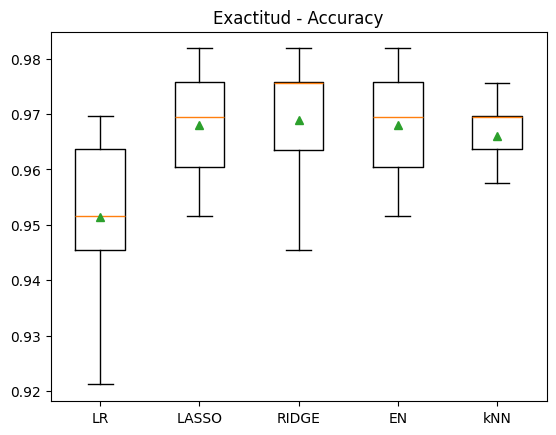

<ipython-input-9-0db74e03d2d4>:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados2, labels=nombres,  showmeans=True)


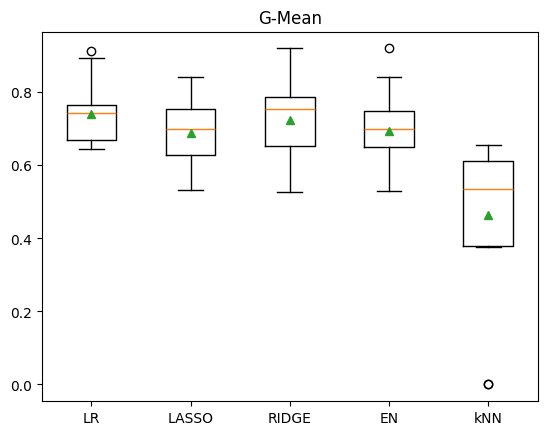

In [ ]:
# Código-2:
# ACCURACY & G-mean

def mis_modelos1():
  modelos, nombres = list(), list()

  modelos.append(LogisticRegression(penalty=None,
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LR')


  modelos.append(LogisticRegression(penalty='l1',
                                    solver='liblinear',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('LASSO')


  modelos.append(LogisticRegression(penalty='l2',
                                    max_iter=2000,
                                    random_state=1))
  nombres.append('RIDGE')

  modelos.append(LogisticRegression(penalty='elasticnet',
                                    l1_ratio=0.5,
                                    solver='saga',
                                    max_iter=5000,
                                    random_state=1))
  nombres.append('EN')

  modelos.append(KNeighborsClassifier(n_neighbors=5))
  nombres.append('kNN')

  return modelos, nombres

# +++++++++++++++++++++++++++++++


modelos, nombres = mis_modelos1()
resultados1, resultados2 = list(), list()
print('Resultados de Validación:')

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
  scores = cross_validate(pipeline,
                          Xtv,
                          np.ravel(ytv),
                          scoring={'exactitud':'accuracy', 'm_geo':mi_metrica},
                          cv=cv1)

  resultados1.append(scores['test_exactitud'])
  resultados2.append(scores['test_m_geo'])

  print(nombres[i])
  print('Exactitud: >> %.3f (%.3f)' % (np.nanmean(scores['test_exactitud']), np.nanstd(scores['test_exactitud'])))
  print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
  print()

plt.boxplot(resultados1, labels=nombres,  showmeans=True)
plt.title("Exactitud - Accuracy")
plt.show()

plt.boxplot(resultados2, labels=nombres,  showmeans=True)
plt.title("G-Mean")
plt.show()


# **Ejercicio-2**

### **Explica por qué la salida y gráficos anteriores nos ayudan a respaldar la decisión de usar la métrica G-mean, en lugar de la exactitud (accuracy) en este problema:**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



La salida y los gráficos muestran que la métrica de accuracy es consistentemente alta para todos los modelos, con valores cercanos al 0.95-0.97. Sin embargo, la métrica G-mean revela una diferencia clave: aunque algunos modelos tienen una alta exactitud, su capacidad para manejar el desbalance en la clasificación es muy diferente. Si solo miráramos la exactitud, podríamos concluir que todos los modelos tienen un rendimiento similar; sin embargo, G-mean nos muestra que algunos modelos, como LASSO y EN, tienen un rendimiento más bajo en términos de balance de los datos. Esto es debido a que esta
métrica es independiente de la distribución de los casos entre clases.




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-3**

### **Utilizando en adelante solamente la métrica G-mean y de manera análoga al código de la celda llamada "Código-2" anterior, define una función llamada "mis_modelos2()" y utilízala para definir los mismos modelos de regresión logística, pero incluyendo el argumento class_weight='balanced'. Los demás hiperparámetros los puedes variar si así lo consideras adecuado. Incluye kNN, aunque no tiene argumento para balanceo de las clases de salida.**

Resultados de Validación con Modelos Balanceados:
LR
G-mean: >> 0.678 (0.118)

LASSO
G-mean: >> 0.849 (0.069)

RIDGE
G-mean: >> 0.852 (0.070)

EN
G-mean: >> 0.851 (0.070)

kNN
G-mean: >> 0.464 (0.204)



<ipython-input-10-ef4d2748aac5>:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados_bal, labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.


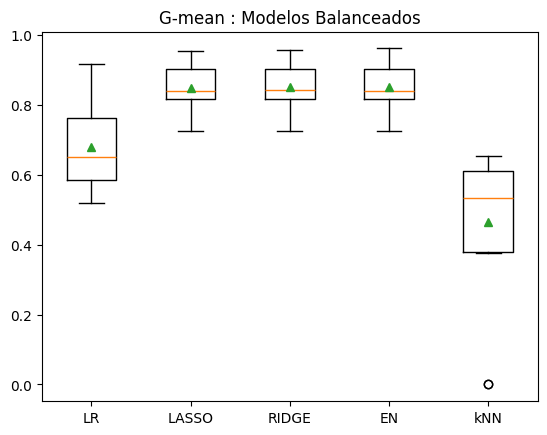

In [ ]:
#  Casos balancedos con hiperparámetro de Regresión Logística:

# ++++++++++ Inicia sección para agregar tu código ++++++++++++++++++++++++

def mis_modelos2():
    modelos, nombres = list(), list()

    # Regresión Logística sin penalización (balanceado)
    modelos.append(LogisticRegression(penalty=None,
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('LR')

    # Regresión Logística con LASSO (L1) y balanceo
    modelos.append(LogisticRegression(penalty='l1',
                                      solver='liblinear',
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('LASSO')

    # Regresión Logística con Ridge (L2) y balanceo
    modelos.append(LogisticRegression(penalty='l2',
                                      class_weight='balanced',
                                      max_iter=2000,
                                      random_state=1))
    nombres.append('RIDGE')

    # Regresión Logística con Elastic Net y balanceo
    modelos.append(LogisticRegression(penalty='elasticnet',
                                      l1_ratio=0.5,
                                      solver='saga',
                                      class_weight='balanced',
                                      max_iter=5000,
                                      random_state=1))
    nombres.append('EN')

    # k-Nearest Neighbors (sin balanceo, ya que no tiene ese argumento)
    modelos.append(KNeighborsClassifier(n_neighbors=5))
    nombres.append('kNN')

    return modelos, nombres


# Llamar a la función para obtener los modelos y nombres
modelos2, nombres2 = mis_modelos2()

# Evaluar con validación cruzada usando G-Mean
resultados_bal = list()

print('Resultados de Validación con Modelos Balanceados:')

for i in range(len(modelos2)):
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos2[i])])
    cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

    scores = cross_validate(pipeline,
                            Xtv,
                            np.ravel(ytv),
                            scoring={'m_geo': mi_metrica},
                            cv=cv1)

    resultados_bal.append(scores['test_m_geo'])

    print(nombres2[i])
    print('G-mean: >> %.3f (%.3f)' % (np.nanmean(scores['test_m_geo']), np.nanstd(scores['test_m_geo'])))
    print()



# ++++++++++ Termina sección para agregar tu código ++++++++++++++++++++++++


plt.boxplot(resultados_bal, labels=nombres2,  showmeans=True)   # gráficos de caja para una comparación visual de los resultados.
plt.title("G-mean : Modelos Balanceados")
plt.show()

# **Ejercicio-4**

### **4a) Selecciona el que consideres sea el mejor modelo encontrado hasta ahora y utilízalo para obtener los gráficos curva-ROC y curva-PR, así como los valores de sus áreas bajo la curva. Sigue utilizando los conjuntos de entrenamiento y validación.**



In [ ]:
mejor_modelo = LogisticRegression(penalty='l2',
                                  solver='liblinear',
                                  class_weight='balanced',
                                  max_iter=2000,
                                  C = 0.50,
                                  random_state=1)

In [ ]:
Xxt = columnasTransformer.fit_transform(Xtrain)
Xxv= columnasTransformer.transform(Xval)
mejor_modelo.fit(Xxt, ytrain)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=2000,
                   random_state=1, solver='liblinear')

In [ ]:
def plot_roc_pr_curves(modelo, y_true, Xx, title_suffix=""):
    y_pred = modelo.predict_proba(Xx)[:,1] #probabilidad de la clase positiva

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = average_precision_score(y_true, y_pred)
    tasa_positiva = len(y_true[y_true==1]) / len(y_true)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.3f}')
    plt.plot([0,0,1,0],[0,1,1,0], 'y--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve {title_suffix}")
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.3f}')
    plt.plot([0,1,1,0],[tasa_positiva,tasa_positiva,1,1], 'y--')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve {title_suffix}")
    plt.grid()
    plt.legend()
    plt.show()
    print(f"AUC-ROC: {auc_roc:.3f}")
    print(f"AUC-PR: {auc_pr:.3f}")

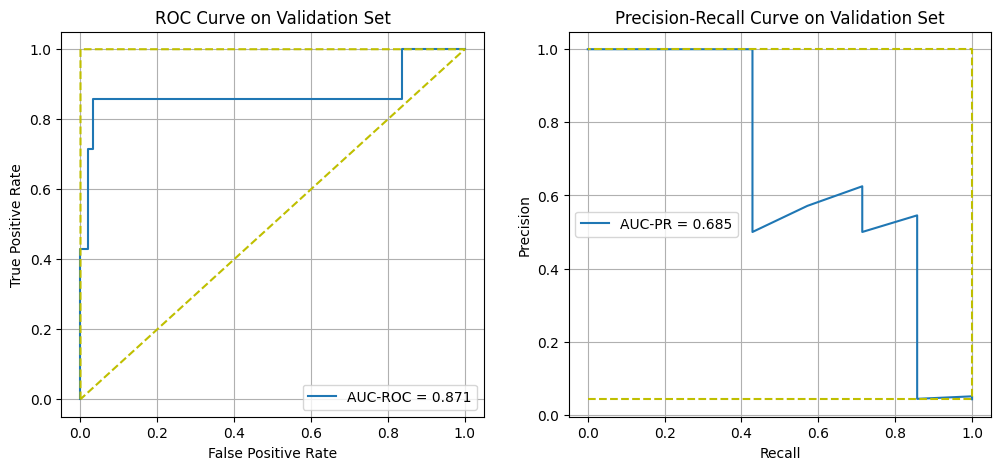

AUC-ROC: 0.871
AUC-PR: 0.685


In [ ]:
plot_roc_pr_curves(mejor_modelo, yval, Xxv, "on Validation Set")

In [ ]:
geometric_mean_score(yval, mejor_modelo.predict(Xxv) )

0.9020771689863955

<ipython-input-16-c68daf90a414>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


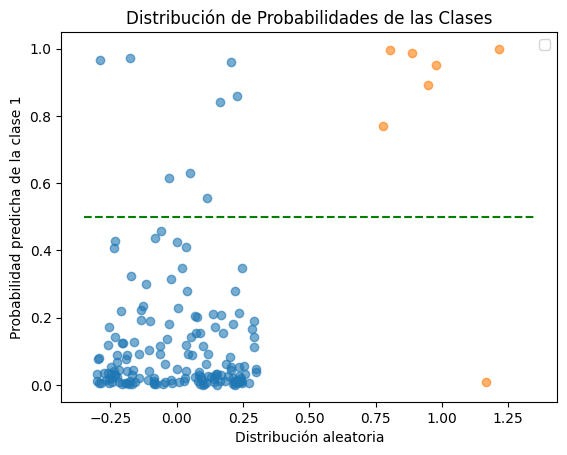

In [ ]:
# Obtenemos los índices de las etiquetas reales de los 0s y 1s
my0s = (yval == 0)  # Índices de clase negativa
my1s = (yval == 1)  # Índices de clase positiva

# Obtenemos las predicciones del modelo en formato probabilístico
pred = mejor_modelo.predict_proba(Xxv)  # Predicciones probabilísticas

# Extraemos las probabilidades de la clase 1 para cada grupo
pred0s = pred[my0s][:, 1]  # Probabilidades de la clase 1 para los casos que son realmente clase negativa
pred1s = pred[my1s][:, 1]  # Probabilidades de la clase 1 para los casos que son realmente clase positiva

# Generamos valores aleatorios para el eje X para mejor visualización
r0 = np.random.uniform(-0.3, 0.3, size=pred0s.shape[0])  # Valores alrededor de 0
r1 = np.random.uniform(0.7, 1.3, size=pred1s.shape[0])   # Valores alrededor de 1

# Graficamos los puntos en un plano 2D
plt.scatter(x=r0, y=pred0s, alpha=0.6)
plt.scatter(x=r1, y=pred1s, alpha=0.6)

# Dibujamos la línea horizontal que denota el umbral de decisión (0.5)
plt.hlines(0.5, -0.35, 1.35, color='g', linestyles='dashed')

# Etiquetas y leyenda
plt.xlabel("Distribución aleatoria")
plt.ylabel("Probabilidad predicha de la clase 1")
plt.legend()
plt.title("Distribución de Probabilidades de las Clases")
plt.show()

### **4b) Incluye tus conclusiones de los gráficos obtenidos en el inciso anterior.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**


Los gráficos muestran un AUC-ROC de 0.871 y un AUC-PR de 0.67. Aunque el ROC refleja que el modelo discrimina bien entre las clases, dado el mismo desbalance de clases, la curva PR es más representativa dado que se centra en la clase minoritaria. El AUC-PR de 0.67 indica que el modelo responde adecuadamente al identificar la clase positiva, sin embargo todavía presenta dificultades en su rendimiento.




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

# **Ejercicio-5**

### **Utiliza el conjunto de prueba (test) para evaluar el mejor modelo obtenido.**

In [ ]:
# **+++++++++++ Inicia sección para agregar código ++++++++++++++++**
# NOTA: puedes agregar todas las celdas que consideres adecuado.
Xt= columnasTransformer.transform(Xtest)
y_pred = mejor_modelo.predict(Xt)

accuracy = accuracy_score(np.ravel(ytest), y_pred)
precision = precision_score(np.ravel(ytest), y_pred)
recall = recall_score(np.ravel(ytest), y_pred)
f1 = f1_score(np.ravel(ytest), y_pred)
g_mean = geometric_mean_score(np.ravel(ytest), y_pred)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Geometric Mean Score: {g_mean:.4f}")
# **+++++++++++ Termina sección para agregar código ++++++++++++++**

Accuracy: 0.8673
Precision: 0.0833
Recall: 0.2000
F1-score: 0.1176
Geometric Mean Score: 0.4238


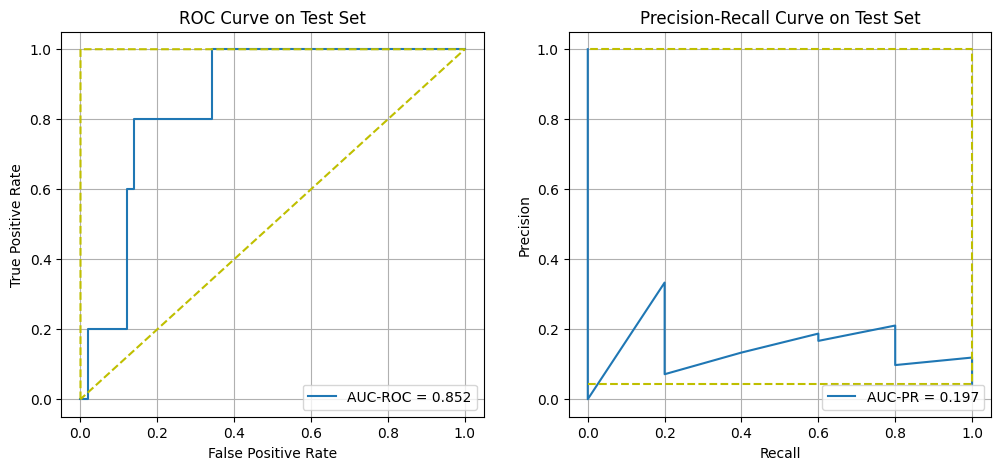

AUC-ROC: 0.852
AUC-PR: 0.197


In [ ]:
plot_roc_pr_curves(mejor_modelo, ytest, Xt, "on Test Set")

# **Ejercicio-6**

### **Incluye tus conclusiones finales de los resultados obtenidos y de la actividad en general.**

**+++++++++++ Inicia sección para agregar texto ++++++++++++++++**



En esta actividad, se exploraron enfoques para la clasificación de clases en un problema con datos desbalanceados, evaluando modelos mediante las métricas más adecuadas. Los resultados obtenidos destacan que el uso de la métrica G-mean permitió identificar el modelo que logra una clasificación más robusta en presencia de desbalance. Además, el análisis de las curvas ROC y PR en presencia de los datos con clases desbalanceadas confirmó la eficacia del modelo seleccionado, proporcionando una validación adicional de su rendimiento a la vez que se observa como funcionan estas curvas. Sin embargo, debido a que en esta actividad no se aplicaron técnicas de muestreo, con el conjunto de prueba no se dieron los resultados más optimos; aun así, con el conjunto de prueba se puede observar como el modelo en presencia de datos desbalanceados presenta un accuracy relativamente alta, con un G-mean más bajo, mostrando la importancia de elegir la metrica más adecuada para cada problema. Finalmente, en esta actividad se pudo explorar el entrenamiento de un modelo de regresión logistica en presenecia de datos desbalanceados con class_weight='balanced', para en un futuro poder tratarlos.




**+++++++++++ Termina sección para agregar texto ++++++++++++++**

## **<<< Fin de la Actividad de la Semana - curvas ROC y PR >>>**